Created: 15.07.2022 <br>
Edited: 02.08.2022 <br>

Trying a different sampling method, as the energy distribution of the neutrinos are different at different times, we sample from time and at that time we sample a recoil energy using the mean neutrino energy and the cross section for that mean neutrino energy. <br>

Author: Melih Kara kara@kit.edu

In [1]:
from astropy import units as u
import numpy as np

hbar = 1.0546e-27*u.cm**2 *u.g / u.s
c_speed = 2.99792458e10*u.cm/u.s # 299792458*u.m/u.s
m_e = 9.109e-31*u.kg

# fixed params for Xe131
Z_Xe = 54
Neu_Xe = 77
A_Xe = Z_Xe + Neu_Xe
amu = 1.66053904e-27*u.kg
m_N = 131.293*amu # 131 * 938.3 # A x rest mass of a proton in MeV

# rest mass of a proton
# p_m = (m_N*c_speed**2).to(u.MeV) / 131.293 # 938.27208816(29) MeV/c2

# mass of the Xenon nucleus in keV
m_Nval = (m_N*(c_speed**2)).to(u.keV)

# these have the units of length
par_a = 0.52*u.fm 
par_c = (1.23*A_Xe**(1./3) - 0.6)*u.fm
par_s = 0.9*u.fm
rn = np.sqrt(par_c**2 + 7./3 * (np.pi*par_a)**2 - 5*par_s**2)

# everything in energy units
aval = (par_a/hbar/c_speed).to(u.keV**-1) #.value # a in keV
cval = (par_c/hbar/c_speed).to(u.keV**-1) #.value # c in keV
sval = (par_s/hbar/c_speed).to(u.keV**-1) #.value # s value in keV
rnval = (rn/hbar/c_speed).to(u.keV**-1) #.value # rn value in keV

In [2]:
sin2theta = 0.2386
Q_W = Neu_Xe - (1-4*sin2theta) * Z_Xe

In [3]:
# natural units 
len_nat = (hbar/(m_e*c_speed)).decompose()
e_nat = (m_e * c_speed**2).to(u.keV)
t_nat = (len_nat / c_speed).to(u.s)

In [4]:
GF = 8.958e-44 * u.MeV * u.cm**3
GFnat = (GF/(hbar*c_speed)**3).to(u.keV**-2)
corrGFmN = len_nat**2 * e_nat**2

In [5]:
term1 = corrGFmN * (GFnat**2) * m_Nval * (Q_W**2) / (4*np.pi)

In [6]:
from scipy.special import spherical_jn
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

plt.style.use('ggplot')

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['xtick.major.pad'] = 5
plt.rcParams['ytick.major.pad'] = 5

plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['xtick.minor.pad'] = 5
plt.rcParams['ytick.minor.pad'] = 5
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['font.size'] = 16

In [7]:
def form_factor(Er):
    """
    Helms Form Factor
    Arguments
    ---------
    Er : Recoil energy (need units)
    Returns 
    -------
    F(E_R) = 3*j_1(q*r_n) / (q*r_n) * exp(-(q*s)^2/2)
    
    """
    Er = Er.to(u.keV) # keV
    q = np.sqrt(2*m_Nval*Er) # keV
    # avoid zero division
    q = np.array([q]) if np.ndim(q)==0 else q
    q[q==0] = np.finfo(float).eps * q.unit
    qrn = q*rnval
    
    # spherical_jn doesn't accept units, feed values
    j1 = spherical_jn(1, qrn.value)     # unitless
    t1 = 3*j1*qrn.unit / qrn
    t2 = np.exp(-0.5 * (q*sval)**2)
    return t1*t2

Er_tests = np.linspace(0,300,1000)*u.keV
ffacts = form_factor(Er_tests)**2

In [8]:
def nN_cross_section(Enu, Er):
    """     neutrino nucleus Cross-Section
    Arguments
    ---------
    Enu : array, Neutrino energies, (needs unit)
    Er : array, Recoil energies, (needs unit)
    Returns
    -------
    dsigma / dE_r:
        neutrino-nucleus cross section in units of m^2 / MeV
    
    Notes:
        GFnat.value : has a unit of keV^-2
        mNval       : has a unit of keV
        corrGFmNval : has a unit of m^2 keV^2 
    """
    # Avoid division by zero in energy PDF below.
    Enu[Enu==0] = np.finfo(float).eps * Enu.unit
    Er[Er==0] = np.finfo(float).eps * Er.unit
    
    ffactor = form_factor(Er)**2 * term1
    xsec = np.zeros(shape=(len(Enu), len(Er)))
    xsec = ffactor[:, np.newaxis] * (1-0.5*m_Nval*np.outer(Er, Enu**-2.))
    xsec[xsec<0] = 0

    return xsec

In [9]:
# Further visualise the cross section for different neutrino energies with different recoil energies
Enu_vals = np.linspace(0,100,100)*u.MeV
Er_vals = np.linspace(0,15,150)*u.keV
cs_test = nN_cross_section(Enu_vals, Er_vals)
cs_test.shape

(150, 100)

/tmp/jobs/21865626/ipykernel_82/387022128.py:1: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.pcolormesh(cs_test*1e43, cmap='PuBu') #,norm=matplotlib.colors.LogNorm())
/tmp/jobs/21865626/ipykernel_82/387022128.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbb = plt.colorbar(cb)


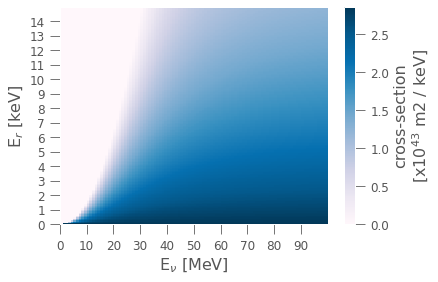

In [10]:
cb = plt.pcolormesh(cs_test*1e43, cmap='PuBu') #,norm=matplotlib.colors.LogNorm())
plt.xlabel(r'E$_\nu$ [MeV]', fontsize=16); plt.ylabel(r'E$_r$ [keV]', fontsize=16);
cbb = plt.colorbar(cb)
cbb.set_label('cross-section\n' 
              fr'[x$10^{{43}}$ {cs_test.unit}]', fontsize=16);
plt.xticks(ticks=np.arange(0,100,10));
plt.yticks(ticks=np.arange(0,150,10), labels=np.arange(0,15,1));

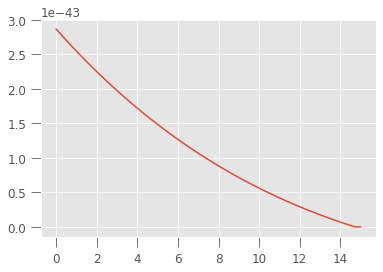

In [13]:
example_nu = 30
sigmas = nN_cross_section([example_nu]*u.MeV, Er_vals)
plt.plot(Er_vals, sigmas);

In [14]:
import snewpy
from snewpy.models.ccsn import Bollig_2016
from snewpy.neutrino import Flavor
import os
from tqdm.notebook import tqdm

In [21]:
file_path = os.path.join("/dali/lgrandi/melih/mma/data/snewpy_models/", 'Bollig_2016/s11.2c')
model = Bollig_2016(file_path, 'LS220')

In [22]:
times = model.time
lum = model.luminosity
alpha = model.pinch
meanE = model.meanE

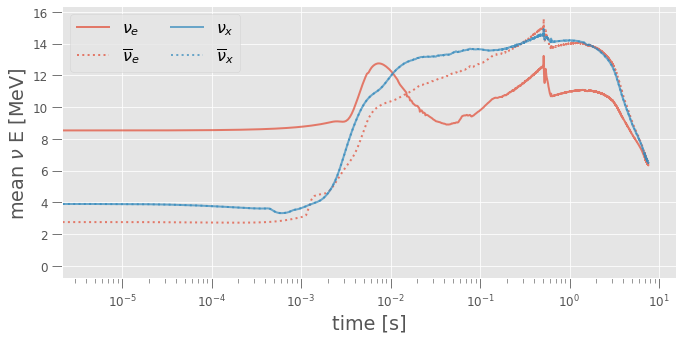

In [24]:
fig, ax = plt.subplots(figsize=(11,5))
for flavor in Flavor:
    kwargs = dict(label=flavor.to_tex(), color='C0' if flavor.is_electron else 'C1',
                  ls='-' if flavor.is_neutrino else ':', lw=2, alpha=0.7)
    ax.plot(model.time, meanE[flavor], **kwargs)

ax.set_xscale('log')
ax.legend(loc='upper left', ncol=2, fontsize=16)
ax.set(ylabel=r'mean $\nu$ E [MeV]', xlabel='time [s]');

In [25]:
init_spec = model.get_initial_spectra(50*u.ms, 10*u.MeV)

In [26]:
# define some neutrino energies
Enu_vals = np.linspace(0,150,100)*u.MeV
ispec_t = model.get_initial_spectra(50*u.ms, Enu_vals) # init spect, oscillated possible
fluxunit = ispec_t[Flavor.NU_E].unit

# for different times, it does not work, so we tweak
# notice, the times are way too much, so we sparse it
_times = times #[::10]
# construct a dictionary containing each {flavorname-array} pairs for each flavor
ispec_E = {f:np.zeros(len(_times))*fluxunit for f in Flavor}
for i, t in tqdm(enumerate(_times), total=len(_times)):
    temp = model.get_initial_spectra(t, 10*u.MeV)
    for f in Flavor:
        ispec_E[f][i] = temp[f]

  0%|          | 0/12380 [00:00<?, ?it/s]

In [27]:
from scipy.special import loggamma

# this function takes the spectra and scales for distance
def nu_flux(model, t, Enu_arr, distance=10*u.kpc, flavors=Flavor):
    """ Neutrino flux for a given neutrino energy at a given time
        t         : time (need units)
        Enu_arr   : neutrino energies (need units)
        dist      : the distance to the SN (need units)

    Returns
    dictionary containing each flavor
        fluxes at each energies at a given time in units of [1/MeV/m/s]
    """
    initial_spectra = model.get_initial_spectra(t, Enu_arr, flavors=flavors)
    # initial_spectra has the fluxes at the source, we scale by distance
    for f in flavors:
        initial_spectra[f] /= (distance**2).to(u.m**2) * 4*np.pi
    return initial_spectra

In [28]:
%%time
# integrate the fluxes over all times
sampled_times = model.time #[::50]
_testflux = model.get_initial_spectra(sampled_times[0], Enu_vals[0])[Flavor.NU_E]
_fluxes = np.zeros((len(sampled_times), len(Enu_vals))) * _testflux.unit
_fluxes = {f:_fluxes.copy() for f in Flavor}

for f in tqdm(Flavor, total=4):
    for i, sec in tqdm(enumerate(sampled_times), total=len(sampled_times), desc=f.to_tex(), leave=False):
        _fluxes_dict = model.get_initial_spectra(sec, Enu_vals)
        _fluxes[f][i,:] = _fluxes_dict[f]

  0%|          | 0/4 [00:00<?, ?it/s]

$\nu_e$:   0%|          | 0/12380 [00:00<?, ?it/s]

$\overline{\nu}_e$:   0%|          | 0/12380 [00:00<?, ?it/s]

$\nu_x$:   0%|          | 0/12380 [00:00<?, ?it/s]

$\overline{\nu}_x$:   0%|          | 0/12380 [00:00<?, ?it/s]

CPU times: user 1min 44s, sys: 332 ms, total: 1min 44s
Wall time: 1min 44s


In [29]:
time_integrated_fluxes = {f:np.trapz(_fluxes[f], sampled_times, axis=0) for f in Flavor}

In [30]:
# time_integfluxes_MeV = time_integrated_fluxes.to(1/u.MeV)
time_integfluxes_MeV = {f:time_integrated_fluxes[f].to(1/u.MeV) for f in Flavor}
def dRdEr_integrand(Enu, Er, f=Flavor.NU_E):
    """ integration passes both in MeV
    """
    # first get the cross-section
    xsec = nN_cross_section(np.array([Enu])*u.MeV, [Er]*u.MeV)[0]
    xsecval = xsec.to(u.m**2 / u.MeV).value # m^2/MeV
    flux_t = np.interp(Enu, Enu_vals.value, time_integfluxes_MeV[f].value)
    return flux_t * xsecval

import scipy.integrate as sintegrate
@np.vectorize
def dRdEr(ErMeV):
    """ Er has to be in MeV
    """
    minE = np.sqrt(0.5*m_Nval.to_value("MeV")*ErMeV)
    y, err = sintegrate.quad(dRdEr_integrand, minE, 100, args=(ErMeV)) 
    return y

In [31]:
N_Xe = 4.6e27*u.count/u.tonne
scale = (4*np.pi*(10*u.kpc)**2).to(u.m**2)

In [32]:
neutrino_energy_sampling = np.linspace(0,200,300)*u.MeV
xsec = nN_cross_section(neutrino_energy_sampling, [0.001]*u.MeV)[0].to(u.m**2 / u.MeV)
flux = np.interp(neutrino_energy_sampling, Enu_vals, time_integfluxes_MeV[Flavor.NU_E])
value = np.trapz((xsec*flux), neutrino_energy_sampling)

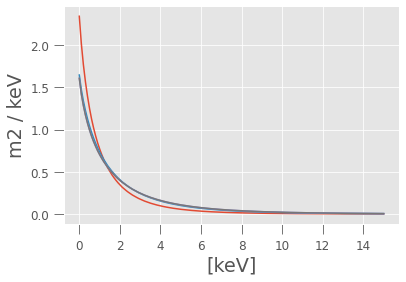

In [33]:
test = {f:np.zeros(len(Er_vals))*(u.m**2/u.keV) for f in Flavor}
flux = {f:np.interp(neutrino_energy_sampling, Enu_vals, time_integfluxes_MeV[f]) for f in Flavor}

for f in Flavor:
    for i, Er in enumerate(Er_vals):
        xsec = nN_cross_section(neutrino_energy_sampling, [Er.value]*Er.unit)[0]
        test[f][i] = np.trapz((xsec*flux[f]), neutrino_energy_sampling).to(u.m**2/u.keV)
    plt.plot(Er_vals, test[f]*N_Xe/scale)
    
plt.xlabel(f'[{Er_vals.unit}]')
plt.ylabel(f"{test[f].unit}");

In [34]:
interpolate_Enu = np.interp(123, Enu_vals.value, _fluxes[Flavor.NU_E][0,:])

In [35]:
neutrino_energy_sampling = np.linspace(0,200,300)*u.MeV
time_fluxes = {f:np.zeros(shape=(len(model.time), len(neutrino_energy_sampling)))*_fluxes[f].unit for f in Flavor}
for i, t in tqdm(enumerate(model.time), total=len(model.time)):
    for f in Flavor:
        time_fluxes[f][i] = np.interp(neutrino_energy_sampling, Enu_vals, _fluxes[f][i,:])

  0%|          | 0/12380 [00:00<?, ?it/s]

In [36]:
xsecs = nN_cross_section(neutrino_energy_sampling, Er_vals).to(u.m**2 / u.MeV)
xsecs.shape, xsecs.unit

((150, 300), Unit("m2 / MeV"))

In [37]:
xsecs_integrated = np.trapz(xsecs, Er_vals, axis=0)

In [38]:
time_fluxes_integrated = {}
time_fluxes_integrated = {f:np.trapz(time_fluxes[f].to(u.MeV**-1 * u.s**-1)*xsecs_integrated, 
                                     neutrino_energy_sampling, axis=-1).to(u.m**2/u.s) for f in Flavor}

_total = np.zeros_like(time_fluxes_integrated[f])
for f in Flavor:
    _total += time_fluxes_integrated[f]
time_fluxes_integrated["Total"] = _total

In [48]:
def get_rates(model, 
              neutrino_energies=np.linspace(0,200,300)*u.MeV, 
              recoil_energies=np.linspace(0,20,100)*u.keV, 
              plot=True,
              distance=10*u.kpc):
    N_Xe = 4.6e27*u.count/u.tonne
    scale = (4*np.pi*(distance)**2).to(u.m**2)
    flux_unit = model.get_initial_spectra(1*u.s, 100*u.MeV)[Flavor.NU_E].unit
    _fluxes2 = np.zeros((len(model.time), len(neutrino_energies))) * flux_unit
    _fluxes2 = {f:_fluxes2.copy() for f in Flavor}

    # get fluxes at each time and at each neutrino energy
    for f in tqdm(Flavor, total=len(Flavor)):
        for i, sec in tqdm(enumerate(model.time), total=len(model.time), desc=f.to_tex(), leave=False):
            _fluxes_dict = model.get_initial_spectra(sec, neutrino_energies)
            _fluxes2[f][i,:] = _fluxes_dict[f]

    # get rates per recoil energy after SN duration
    rates_per_Er = {f:np.zeros(len(recoil_energies)) for f in Flavor}
    # integrate over time
    fluxes_per_Er = {f:np.trapz(_fluxes2[f], model.time, axis=0).to(1/u.keV) for f in Flavor} 
    # get cross sections
    xsecs = nN_cross_section(neutrino_energies, recoil_energies)
    
    integ = {f:(xsecs*fluxes_per_Er[f]) for f in Flavor}
    rates_per_Er = {f:np.trapz(integ[f], neutrino_energies, axis=1).to(u.m**2/u.keV) for f in Flavor}

    # get rates per time, from all neutrino energies
    # integrate over recoil energies
    xsecs_integrated = np.trapz(xsecs, recoil_energies, axis=0) 
    flux_x_xsec = {f:_fluxes2[f]*xsecs_integrated for f in Flavor}
    # integrate over nu energies
    rates_per_t = {f:np.trapz(flux_x_xsec[f], neutrino_energies, axis=1).to(u.m**2/u.s) for f in Flavor} 
    total_flux = np.zeros_like(rates_per_t[Flavor.NU_E])

    # add the total fluxes
    for rate in [rates_per_Er, rates_per_t]:
        total_flux = np.zeros_like(rate[Flavor.NU_E])
        for f in Flavor:
            if not f.is_electron:
                _rate = rate[f]*2 # x-neutrinos are for muan and tau
            else:
                _rate = rate[f]
            total_flux += _rate #[f]
        rate["Total"] = total_flux
            
    # add some more info
    rates_per_Er = {**rates_per_Er, **model.metadata}
    rates_per_t = {**rates_per_t, **model.metadata}
    rates_per_Er["distance"] = distance
    rates_per_t["distance"] = distance
    
    # plot if asked
    title_text = (repr(model._repr_markdown_)).split("_repr_markdown_ of")[1].split("\n")[0]
    if plot:
        fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(18,6))
        for f in Flavor:
            ax1.semilogx(model.time, rates_per_t[f]*N_Xe/scale, label=f.to_tex())
            ax2.plot(recoil_energies, rates_per_Er[f]*N_Xe/scale, label=f.to_tex())
        ax1.semilogx(model.time, rates_per_t["Total"]*N_Xe/scale, label="Total")
        ax2.plot(recoil_energies, rates_per_Er["Total"]*N_Xe/scale, label="Total")
        ax1.legend(ncol=2, fontsize=15);  ax2.legend(ncol=5, fontsize=15);
        ax1.set(xlabel=model.time.unit, ylabel=(rates_per_t[f]*N_Xe/scale).unit, title=title_text)
        ax2.set(xlabel=recoil_energies.unit, ylabel=(rates_per_Er[f]*N_Xe/scale).unit, title=title_text)
        ax1.tick_params(axis='both', which='major', labelsize=17)
        ax2.tick_params(axis='both', which='major', labelsize=17)
        ax1.xaxis.label.set_size(17); ax2.xaxis.label.set_size(17)
        ax1.yaxis.label.set_size(17); ax2.yaxis.label.set_size(17)
        xlim = ax2.set_xlim(); ylim = ax2.set_ylim()
        text = "\n".join([f"{k:>15}:{v:<10}" for k,v in model.metadata.items()])
        ax2.text(np.mean(xlim)-np.mean(xlim)/2, np.mean(ylim), text, fontsize=17)
    rates_per_Er["name"] = title_text
    rates_per_t["name"] = title_text
    return rates_per_Er, rates_per_t

---

In [43]:
from scipy import interpolate
def _inverse_transform_sampling(x_vals, y_vals, n_samples):
    cum_values = np.zeros(x_vals.shape)
    y_mid = (y_vals[1:] + y_vals[:-1]) * 0.5
    cum_values[1:] = np.cumsum(y_mid * np.diff(x_vals))
    inv_cdf = interpolate.interp1d(cum_values / np.max(cum_values), x_vals)
    r = np.random.rand(n_samples)
    return inv_cdf(r)

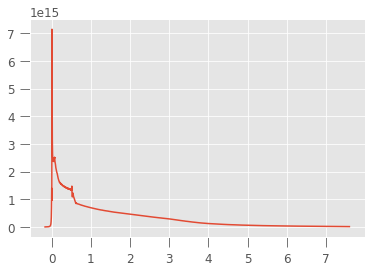

In [44]:
plt.plot(model.time, time_fluxes_integrated["Total"]);

In [45]:
sampled_time = _inverse_transform_sampling(model.time, time_fluxes_integrated["Total"], 10000)

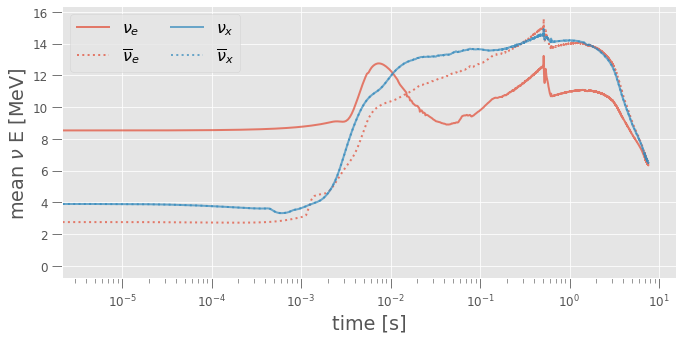

In [46]:
fig, ax = plt.subplots(figsize=(11,5))
for flavor in Flavor:
    kwargs = dict(label=flavor.to_tex(), color='C0' if flavor.is_electron else 'C1',
                  ls='-' if flavor.is_neutrino else ':', lw=2, alpha=0.7)
    ax.plot(model.time, meanE[flavor], **kwargs)

ax.set_xscale('log')
ax.legend(loc='upper left', ncol=2, fontsize=16)
ax.set(ylabel=r'mean $\nu$ E [MeV]', xlabel='time [s]');

In [51]:
sampled_meanE = np.interp(sampled_time*u.s, model.time, model.meanE[Flavor.NU_E])

/tmp/jobs/21865626/ipykernel_82/2216894211.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbb = plt.colorbar(cb)


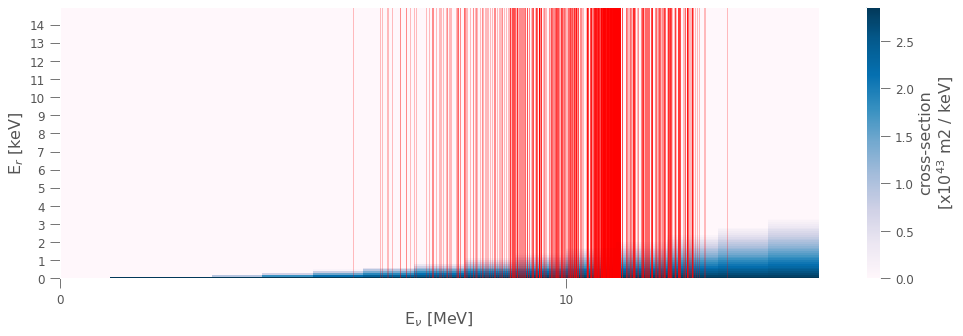

In [57]:
plt.figure(figsize=(17,5))
plt.grid(False)
cb = plt.pcolormesh(cs_test*1e43, cmap='PuBu') #,norm=matplotlib.colors.LogNorm())
plt.xlabel(r'E$_\nu$ [MeV]', fontsize=16); plt.ylabel(r'E$_r$ [keV]', fontsize=16);
cbb = plt.colorbar(cb)
cbb.set_label('cross-section\n' 
              fr'[x$10^{{43}}$ {cs_test.unit}]', fontsize=16);
plt.xticks(ticks=np.arange(0,100,10));
plt.yticks(ticks=np.arange(0,150,10), labels=np.arange(0,15,1));
for e in sampled_meanE[::10]:
    plt.axvline(e.value, color='r', lw=0.5, alpha=0.5)
    
plt.xlim(0, 15);

In [58]:
Er_vals = np.linspace(0,15,150)*u.keV
xsec_for_sampled = nN_cross_section(sampled_meanE, Er_vals)

In [59]:
Er_vals.shape, sampled_meanE.shape, xsec_for_sampled.shape

((150,), (10000,), (150, 10000))

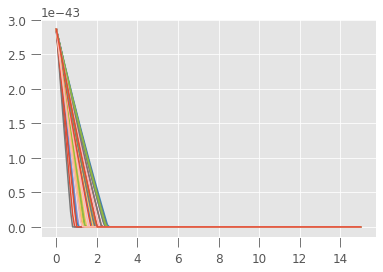

In [62]:
for i, _ in enumerate(sampled_meanE[::200]): 
    plt.plot(Er_vals, xsec_for_sampled[:,i])

In [63]:
sampled_Er = np.zeros(len(sampled_meanE))
for i, meane in enumerate(sampled_meanE):
    sampled_Er[i] = _inverse_transform_sampling(Er_vals, xsec_for_sampled[:,i], 1)

Text(0, 0.5, 'Rate')

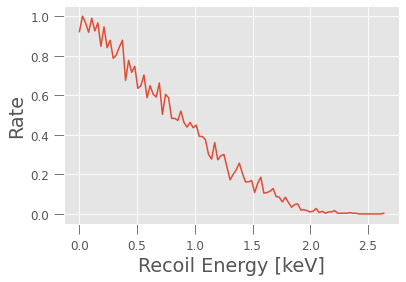

In [69]:
a, b = np.histogram(sampled_Er, bins=100);
plt.plot(b[:-1], a/a.max())
plt.xlabel("Recoil Energy [keV]")
plt.ylabel("Rate")